In [502]:
import os
import numpy as np
import pandas as pd
import csv
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow as tf
from keras.models import load_model, Sequential, Model
from keras.layers import Dense, Dropout, Softmax, BatchNormalization
from keras.initializers import GlorotNormal, GlorotUniform
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [503]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [504]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


## Brain Tumor Classifier

### ConvNet

Dataset: https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri

Acknowledgements for Dataset.
Navoneel Chakrabarty
Swati Kanchan

Team
Sartaj Bhuvaji
Ankita Kadam
Prajakta Bhumkar
Sameer Dedge


#### Import Data


In [505]:
base_dir = './data'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

(512, 512, 3)


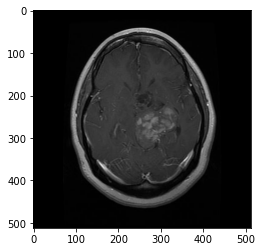

In [506]:
img = plt.imread(f'{train_dir}/glioma_tumor/gg (1).jpg')
print(img.shape)
plt.imshow(img)

(512, 512, 3)


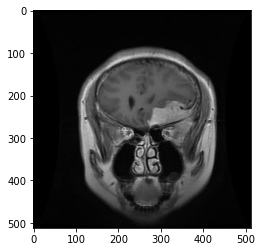

In [507]:
img = plt.imread(f'{train_dir}/meningioma_tumor/m (10).jpg')
print(img.shape)
plt.imshow(img)

In [508]:
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('./data','Training',i)
    for j in os.listdir(folderPath):
        try:
            img = cv2.imread(os.path.join(folderPath,j))
            img = cv2.resize(img,(image_size, image_size))
            X_train.append(img)
            y_train.append(i)
        except:
            print(os.path.join(folderPath,j))
        
for i in labels:
    folderPath = os.path.join('./data','Testing',i)
    for j in os.listdir(folderPath):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [509]:
train_datagen = ImageDataGenerator(validation_split=0.1)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  
        shuffle=True,
        subset='training',
        class_mode='categorical')
val_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150), 
        shuffle=True,
        subset='validation',
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=1,
        target_size=(150, 150),
        class_mode='categorical')

Found 2585 images belonging to 4 classes.
Found 285 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [510]:
train_df = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(150, 150),
    seed=101,
    validation_split=0.1,
    subset='training')
val_df = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(150, 150),
    seed=101,
    validation_split=0.1,
    subset='validation')
test_df = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(150, 150),
    seed=101)

Found 2870 files belonging to 4 classes.
Using 2583 files for training.
Found 2870 files belonging to 4 classes.
Using 287 files for validation.
Found 394 files belonging to 4 classes.


#### Transfer Learning

In [511]:
base_model = InceptionV3(weights='imagenet', 
                      input_shape=(150, 150, 3), 
                      include_top=False,
                      pooling='avg')
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_752 (Conv2D)             (None, 74, 74, 32)   864         input_28[0][0]                   
__________________________________________________________________________________________________
batch_normalization_752 (BatchN (None, 74, 74, 32)   96          conv2d_752[0][0]                 
__________________________________________________________________________________________________
activation_752 (Activation)     (None, 74, 74, 32)   0           batch_normalization_752[0][0]    
_______________________________________________________________________________________

#### Trainning

In [512]:
#### Trainning Callbacks
def _get_checkpoint_cb(path, experiment_id, eval_metric):
    return ModelCheckpoint(filepath=f"{path}/experiment_{experiment_id}/checkpoint_{experiment_id}", 
                                                               save_weights_only = True,
                                                               monitor = f'val_{eval_metric}',
                                                               save_best_only = True,
                                                               verbose = 1)

def _get_early_stopping_cb(path, experiment_id, eval_metric):
    return EarlyStopping(monitor = f'val_{eval_metric}', patience = 4, restore_best_weights = True)

def _get_tensorboard_cb(path, experiment_id, eval_metric):
    return TensorBoard(log_dir=f"{path}/logs/tensorboard/experiment_{experiment_id}", 
                                          histogram_freq=10, 
                                          write_graph=True, 
                                          write_images=False, 
                                          write_steps_per_second=False, 
                                          update_freq="epoch", 
                                          profile_batch=2, 
                                          embeddings_freq=10, 
                                          embeddings_metadata=None)

In [513]:
from os.path import exists

class ConvNetExperiments():
    def __init__(self, results_path, eval_metric, batch_size, epochs=20, val_split=0.2, training_callbacks = None, evaluation_cb=None):
        self.path = results_path
        self.current_model = None
        self.current_history = None
        self.eval_metric = eval_metric
        self.epochs = epochs
        self.batch_size = batch_size
        self.val_split = val_split
        self._callbacks = []
        self.evaluation_cb = evaluation_cb
        self._init_files()
        print(f"Current Experiment Id = {self._current_experiment_id}")
        
    def _init_files(self):
        file_exists = exists(f'{self.path}/logs/models.npy')
        if not file_exists:
            self._current_experiment_id = 0
            self.update_experiment_id()
        else:
            self._current_experiment_id = np.load(f'{self.path}/logs/models.npy')[0]
        
        ### experiments file
        path = f'{self.path}/logs/experiments.csv'
        file_exists = exists(path)
        if not file_exists:
            header = ["ExperimentID", "Datetime", f"train_{self.eval_metric}" ,f"val_{self.eval_metric}"]
            with open(path, '+w') as f:
                # create the csv writer
                writer = csv.writer(f)
                # write a row to the csv file
                writer.writerow(header)
        ### results file
        path = f'{self.path}/logs/test_results.csv'
        file_exists = exists(path)
        if not file_exists:
            header = ["ExperimentID", "Datetime", "test_loss" ,f"test_{self.eval_metric}"] if not self.evaluation_cb else ["ExperimentID", "Datetime", "test_loss" ,f"test_{self.eval_metric}", "custom_metric"]
            with open(path, '+w') as f:
                # create the csv writer
                writer = csv.writer(f)
                # write a row to the csv file
                writer.writerow(header)
                                                    
    
    def add_callback(self, build_cb):
        self._callbacks.append(build_cb)
        return self

    def run_experiment(self, model, train_x, train_y=None, batch_size=None, class_weight=None, verbose=1):
        self.current_model = model
        self.current_history = model.fit(
                                        x = train_x,
                                        y = train_y,
                                        epochs = self.epochs,
                                        verbose=verbose,
                                        shuffle=True,
                                        batch_size = batch_size or self.batch_size,
                                        validation_split = self.val_split,
                                        callbacks = list(map(lambda build_cb: build_cb(self.path, self._current_experiment_id, self.eval_metric), self._callbacks)),
                                        class_weight=class_weight)
        self._current_experiment_id += 1
        self.save_experiment()
        return self.current_model, self._current_experiment_id
    
    def run_experiment_generator(self, model, train_gen, val_gen, verbose=1):
        self.current_model = model
        self.current_history = model.fit(
                                        train_gen,
                                        epochs = self.epochs,
                                        verbose=verbose,
                                        shuffle=True,
                                        validation_data = val_gen,
                                        callbacks = list(map(lambda build_cb: build_cb(self.path, self._current_experiment_id, self.eval_metric), self._callbacks)))
        self._current_experiment_id += 1
        self.save_experiment()
        return self.current_model, self._current_experiment_id
    
    def update_experiment_id(self):
        np.save(f'{self.path}/logs/models.npy', [self._current_experiment_id])
        
    def save_experiment(self):
        experiment_id = self.get_current_experiment_id()
        self.update_experiment_id()
        history = self.current_history.history
        train_result = history[self.eval_metric][len(history[self.eval_metric]) - 1]
        val_result = history[f"val_{self.eval_metric}"][len(history[f"val_{self.eval_metric}"]) - 1]
        self.current_model.save(f"{self.path}/experiment_{experiment_id}")
        res = pd.DataFrame({'ExperimentId': experiment_id, 'Datetime': datetime.now().strftime("%Y%m%d-%H:%M:%S"), 
                            f"train_{self.eval_metric}": train_result, 
                            f"val_{self.eval_metric}": val_result}, index=[0])
        res.to_csv(f'{self.path}/logs/experiments.csv', mode='+a', index = False, header = False)
            
    def plot_model_loss(self, metric=None):
        if not self.current_history:
            return None
        history = self.current_history
        plt.figure(self.get_current_experiment_id())
        plt.plot(history.history[metric or 'loss'])
        plt.plot(history.history[f'val_{metric or "loss"}'])
        plt.legend(['Training', 'Validation'])
        plt.title(f'Train/Val {metric or "Loss"} {self.get_current_experiment_id()}')
        plt.xlabel('Epoch') 
        plt.show()
            
    
    def get_model(self, model_id=None):
        return load_model(f"{self.path}/experiment_{model_id}") if model_id else self.current_model
    
    def summary_experiments(self):
        return pd.read_csv(f'{self.path}/logs/experiments.csv').sort_values(by = f"val_{self.eval_metric}")
    
    def get_current_experiment_id(self):
        return self._current_experiment_id
    
    def save_results(self, test_loss, test_metric, custom_metric=None):
        res = pd.DataFrame({'ExperimentId': self.get_current_experiment_id(), 'Datetime': datetime.now().strftime("%Y%m%d-%H:%M:%S"), 
         f"test_loss": test_loss, f"test_{self.eval_metric}": test_metric, "test_metric": custom_metric}, index=[0])
        res.to_csv(f'{self.path}/logs/test_results.csv', mode='+a', index = False, header = False)
            
    def test(self, x_test, y_test=None):
        if not self.current_model:
            raise Exception("No model trained")
        test_loss, test_metric = self.current_model.evaluate(x_test, y_test)
        self.save_results(test_loss, test_metric, None)
# return metrics.classification_report(y_true, y_hat, digits=3)
        return test_loss, test_metric

    def compare_test_results(self):
        return pd.read_csv(f'{self.path}/logs/test_results.csv')
    
    def predict(self, x_test):
        if not self.current_model:
            raise Exception("No model trained")
        return self.current_model.predict(x_test)
    
    def set_current_model(self, model_id):
        try:
            self.current_model = self.get_model(model_id)
        except:
            raise Exception("Error al cargar modelo. Verificar Id de Modelo.")



In [514]:
def plot_filters(model, example):
    pass

def plot_feature_maps(model, example, layer=0, filters_per_row=8):
    layer_outputs = {(layer.name, layer.output) for layer in model.layers if 'conv' in layer.name}
    activation_model = Model(inputs=model.input,outputs=layer_outputs.get_values())
    img = img_to_array(example)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    feature_maps = model.predict(img)
    name = layer_outputs.keys()[layer]
    fm = feature_maps[0]
    print(fm.shape)
    n = fm.shape[-1]
    r, c = n // filters_per_row, filters_per_row
    f, ax = plt.subplots(r,c)

    ### render feature map
    for i in range(r):
        for j in range(c):
            feature_img = feature_map[0, :, :, i + (j * filters_per_row)]
            ax[i,j].imshow(feature_img)
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])

    fig.suptitle(f'Feature Map Layer {layer} {name}', fontsize=16)
    plt.show()

        

In [515]:
experiment_controller = ConvNetExperiments("./brain_tumor", "accuracy", batch_size = 32, epochs=12)

experiment_controller.add_callback(_get_checkpoint_cb).add_callback(_get_tensorboard_cb).add_callback(_get_early_stopping_cb)\
    .add_callback(lambda *x: ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1))

Current Experiment Id = 46


#### Base Line Model

In [516]:
train_datagen = ImageDataGenerator(validation_split=0.1, rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  
        shuffle=True,
        subset='training',
        class_mode='categorical')
val_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150), 
        shuffle=True,
        subset='validation',
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=1,
        target_size=(150, 150),
        class_mode='categorical')

Found 2585 images belonging to 4 classes.
Found 285 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [517]:
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False

freeze_model(base_model)
last_layer = base_model.output
last_layer

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d_16')>

In [518]:
predictions = Dense(4, activation="softmax", kernel_initializer = GlorotNormal())(last_layer)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [519]:
model, exp_id = experiment_controller.run_experiment_generator(model, train_df, val_df)
print("ExperimentId:", exp_id)


Epoch 1/12
81/81 [==============================] - 94s 1s/step - loss: 5.6311 - accuracy: 0.4770 - val_loss: 4.9928 - val_accuracy: 0.5331

Epoch 00001: val_accuracy improved from -inf to 0.53310, saving model to ./brain_tumor/experiment_46\checkpoint_46
Epoch 2/12
81/81 [==============================] - 7s 79ms/step - loss: 2.5285 - accuracy: 0.6307 - val_loss: 2.6509 - val_accuracy: 0.6202

Epoch 00002: val_accuracy improved from 0.53310 to 0.62021, saving model to ./brain_tumor/experiment_46\checkpoint_46
Epoch 3/12
81/81 [==============================] - 7s 80ms/step - loss: 1.9613 - accuracy: 0.6702 - val_loss: 2.3720 - val_accuracy: 0.6864

Epoch 00003: val_accuracy improved from 0.62021 to 0.68641, saving model to ./brain_tumor/experiment_46\checkpoint_46
Epoch 4/12
81/81 [==============================] - 7s 84ms/step - loss: 1.7196 - accuracy: 0.7023 - val_loss: 2.0122 - val_accuracy: 0.6899

Epoch 00004: val_accuracy improved from 0.68641 to 0.68990, saving model to ./brai

INFO:tensorflow:Assets written to: ./brain_tumor/experiment_47\assets


ExperimentId: 47


ExperimentId: 47


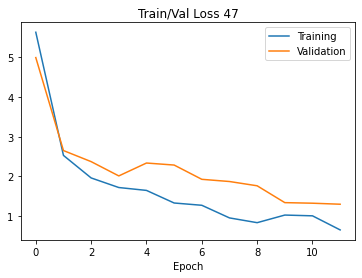

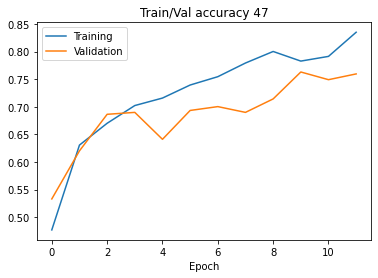

13/13 [==============================] - 1s 53ms/step - loss: 7.8541 - accuracy: 0.6015
(7.854056358337402, 0.6015228629112244)


In [520]:
print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(test_df))

### EfficientNet Does not need the images normalized

In [563]:
train_datagen = ImageDataGenerator(validation_split=0.1)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  
        shuffle=True,
        subset='training',
        class_mode='categorical')
val_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150), 
        shuffle=True,
        subset='validation',
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        class_mode='categorical')

Found 2585 images belonging to 4 classes.
Found 285 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [522]:
#### EfficientNet DF Dataset
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(150,150,3), pooling='avg')

model = effnet.output
model = Dropout(rate=0.5)(model)
model = Dense(4,activation='softmax')(model)
model = Model(inputs=effnet.input, outputs = model)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [523]:
model.summary()

Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_19 (Rescaling)        (None, 150, 150, 3)  0           input_29[0][0]                   
__________________________________________________________________________________________________
normalization_19 (Normalization (None, 150, 150, 3)  7           rescaling_19[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_19[0][0]           
___________________________________________________________________________________________

In [557]:
model, exp_id = experiment_controller.run_experiment(model, X_train, y_train)


Epoch 1/12
74/74 [==============================] - 41s 474ms/step - loss: 1.6295 - accuracy: 0.6420 - val_loss: 0.5004 - val_accuracy: 0.8095

Epoch 00001: val_accuracy improved from -inf to 0.80952, saving model to ./brain_tumor/experiment_60\checkpoint_60
Epoch 2/12
74/74 [==============================] - 14s 194ms/step - loss: 0.3756 - accuracy: 0.8387 - val_loss: 0.2494 - val_accuracy: 0.9065

Epoch 00002: val_accuracy improved from 0.80952 to 0.90646, saving model to ./brain_tumor/experiment_60\checkpoint_60
Epoch 3/12
74/74 [==============================] - 14s 195ms/step - loss: 0.2152 - accuracy: 0.9319 - val_loss: 0.1439 - val_accuracy: 0.9575

Epoch 00003: val_accuracy improved from 0.90646 to 0.95748, saving model to ./brain_tumor/experiment_60\checkpoint_60
Epoch 4/12
74/74 [==============================] - 14s 193ms/step - loss: 0.1516 - accuracy: 0.9613 - val_loss: 0.1108 - val_accuracy: 0.9762

Epoch 00004: val_accuracy improved from 0.95748 to 0.97619, saving model 

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_61\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_61\assets


ExperimentId: 61


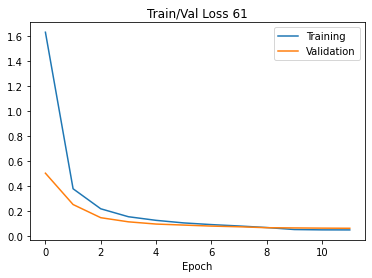

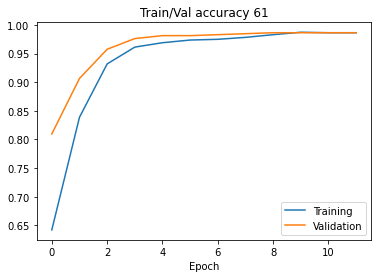

11/11 [==============================] - 0s 39ms/step - loss: 0.0325 - accuracy: 0.9908
(0.03249186649918556, 0.9908257126808167)
11/11 [==============================] - 0s 39ms/step - loss: 0.0325 - accuracy: 0.9908


[0.03249186649918556, 0.9908257126808167]

In [558]:

print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(X_test, y_test))
model.evaluate(X_test, y_test)

**EfficientNetB0 parece trabajar mejor con imagenes sin escalar las entradas**

**Segun la documentacion:**
> and the input data should range [0, 255]. Normalization is included as part of the model.

In [564]:
#### EfficientNet DF Dataset
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(150,150,3), pooling='avg')

model = effnet.output
model = Dropout(rate=0.5)(model)
model = Dense(4,activation='softmax')(model)
model = Model(inputs=effnet.input, outputs = model)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [565]:
model, exp_id = experiment_controller.run_experiment_generator(model, train_generator, val_generator)


Epoch 1/12
81/81 [==============================] - 47s 459ms/step - loss: 0.3887 - accuracy: 0.8561 - val_loss: 1.2691 - val_accuracy: 0.6596

Epoch 00001: val_accuracy improved from -inf to 0.65965, saving model to ./brain_tumor/experiment_62\checkpoint_62
Epoch 2/12
81/81 [==============================] - 17s 206ms/step - loss: 0.1400 - accuracy: 0.9547 - val_loss: 0.5663 - val_accuracy: 0.8386

Epoch 00002: val_accuracy improved from 0.65965 to 0.83860, saving model to ./brain_tumor/experiment_62\checkpoint_62
Epoch 3/12
81/81 [==============================] - 17s 207ms/step - loss: 0.1024 - accuracy: 0.9671 - val_loss: 0.7958 - val_accuracy: 0.7614

Epoch 00003: val_accuracy did not improve from 0.83860
Epoch 4/12
81/81 [==============================] - 17s 207ms/step - loss: 0.0547 - accuracy: 0.9822 - val_loss: 0.6872 - val_accuracy: 0.8632

Epoch 00004: val_accuracy improved from 0.83860 to 0.86316, saving model to ./brain_tumor/experiment_62\checkpoint_62
Epoch 5/12
81/81 [

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_63\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_63\assets


ExperimentId: 63


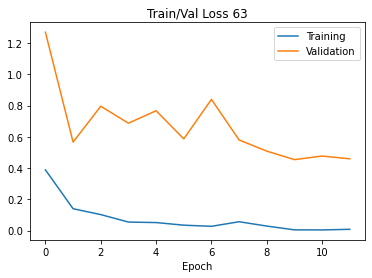

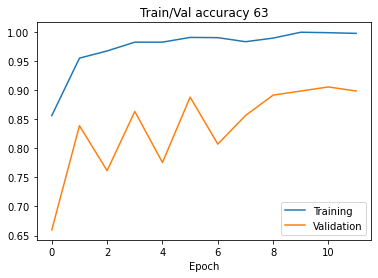

13/13 [==============================] - 2s 129ms/step - loss: 1.9453 - accuracy: 0.7030
(1.9452683925628662, 0.703045666217804)
13/13 [==============================] - 2s 124ms/step - loss: 1.9453 - accuracy: 0.7030


[1.9452683925628662, 0.703045666217804]

In [566]:
print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(test_generator))
model.evaluate(test_generator)

Epoch 1/12
74/74 [==============================] - 41s 343ms/step - loss: 0.4653 - accuracy: 0.8276 - val_loss: 0.7650 - val_accuracy: 0.8571

Epoch 00001: val_accuracy improved from -inf to 0.85714, saving model to ./brain_tumor/experiment_49\checkpoint_49
Epoch 2/12
74/74 [==============================] - 14s 187ms/step - loss: 0.2296 - accuracy: 0.9170 - val_loss: 1.0415 - val_accuracy: 0.8061

Epoch 00002: val_accuracy did not improve from 0.85714
Epoch 3/12
74/74 [==============================] - 14s 190ms/step - loss: 0.1281 - accuracy: 0.9557 - val_loss: 0.4271 - val_accuracy: 0.8844

Epoch 00003: val_accuracy improved from 0.85714 to 0.88435, saving model to ./brain_tumor/experiment_49\checkpoint_49
Epoch 4/12
74/74 [==============================] - 14s 188ms/step - loss: 0.1130 - accuracy: 0.9630 - val_loss: 0.3175 - val_accuracy: 0.9337

Epoch 00004: val_accuracy improved from 0.88435 to 0.93367, saving model to ./brain_tumor/experiment_49\checkpoint_49
Epoch 5/12
74/74 [

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_50\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_50\assets


ExperimentId: 50


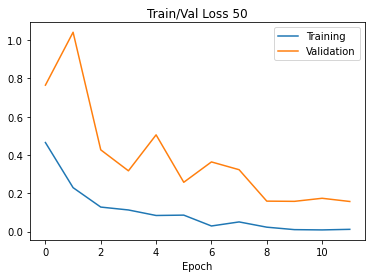

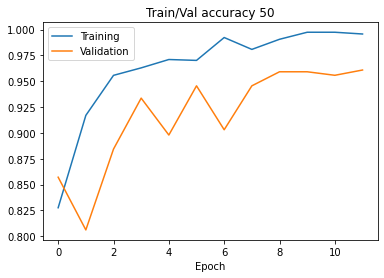

11/11 [==============================] - 0s 39ms/step - loss: 0.1264 - accuracy: 0.9664
(0.12635919451713562, 0.966360867023468)
11/11 [==============================] - 0s 37ms/step - loss: 0.1264 - accuracy: 0.9664


[0.12635919451713562, 0.966360867023468]

In [529]:
#### EfficientNet Flow Image Gen
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(150,150,3), pooling='avg')

model = effnet.output
model = Dropout(rate=0.5)(model)
model = Dense(4,activation='softmax')(model)
model = Model(inputs=effnet.input, outputs = model)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model, exp_id = experiment_controller.run_experiment(model, X_train, y_train)

print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(X_test, y_test))
model.evaluate(X_test, y_test)

Epoch 1/12
74/74 [==============================] - 42s 458ms/step - loss: 0.1540 - accuracy: 0.9570 - val_loss: 2.5790 - val_accuracy: 0.8895

Epoch 00001: val_accuracy improved from -inf to 0.88946, saving model to ./brain_tumor/experiment_50\checkpoint_50
Epoch 2/12
74/74 [==============================] - 14s 189ms/step - loss: 0.0973 - accuracy: 0.9723 - val_loss: 1.1467 - val_accuracy: 0.9116

Epoch 00002: val_accuracy improved from 0.88946 to 0.91156, saving model to ./brain_tumor/experiment_50\checkpoint_50
Epoch 3/12
74/74 [==============================] - 14s 192ms/step - loss: 0.1047 - accuracy: 0.9711 - val_loss: 0.3792 - val_accuracy: 0.9320

Epoch 00003: val_accuracy improved from 0.91156 to 0.93197, saving model to ./brain_tumor/experiment_50\checkpoint_50
Epoch 4/12
74/74 [==============================] - 14s 191ms/step - loss: 0.0613 - accuracy: 0.9800 - val_loss: 0.1677 - val_accuracy: 0.9660

Epoch 00004: val_accuracy improved from 0.93197 to 0.96599, saving model 

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_51\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_51\assets


ExperimentId: 51


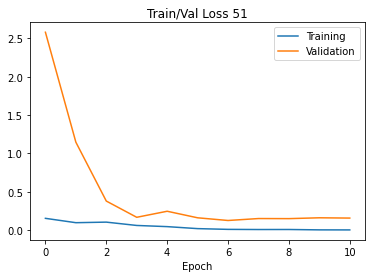

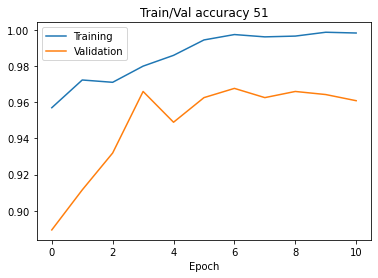

11/11 [==============================] - 0s 39ms/step - loss: 0.0758 - accuracy: 0.9725
(0.07579024881124496, 0.9724770784378052)
11/11 [==============================] - 0s 37ms/step - loss: 0.0758 - accuracy: 0.9725


[0.07579024881124496, 0.9724770784378052]

In [530]:
x = effnet.output
x = Dense(1024, activation = 'relu', kernel_initializer = GlorotNormal())(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation="softmax", kernel_initializer = GlorotUniform())(x)

model = Model(inputs=effnet.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model, exp_id = experiment_controller.run_experiment(model, X_train, y_train)

print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(X_test, y_test))
model.evaluate(X_test, y_test)

#### Adding More Layers

In [531]:
x = effnet.output
x = Dense(1024, activation = 'relu', kernel_initializer = GlorotUniform())(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer = GlorotUniform())(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_initializer = GlorotUniform())(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation="softmax", kernel_initializer = GlorotUniform())(x)



Epoch 1/12
74/74 [==============================] - 43s 474ms/step - loss: 0.1582 - accuracy: 0.9634 - val_loss: 0.5311 - val_accuracy: 0.9524

Epoch 00001: val_accuracy improved from -inf to 0.95238, saving model to ./brain_tumor/experiment_51\checkpoint_51
Epoch 2/12
74/74 [==============================] - 14s 192ms/step - loss: 0.1434 - accuracy: 0.9702 - val_loss: 0.3737 - val_accuracy: 0.9320

Epoch 00002: val_accuracy did not improve from 0.95238
Epoch 3/12
74/74 [==============================] - 14s 192ms/step - loss: 0.1309 - accuracy: 0.9676 - val_loss: 0.7717 - val_accuracy: 0.9524

Epoch 00003: val_accuracy did not improve from 0.95238

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
74/74 [==============================] - 14s 189ms/step - loss: 0.0403 - accuracy: 0.9902 - val_loss: 0.3241 - val_accuracy: 0.9524

Epoch 00004: val_accuracy did not improve from 0.95238
Epoch 5/12
74/74 [==============================] - 14s 190ms/s

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_52\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_52\assets


ExperimentId: 52


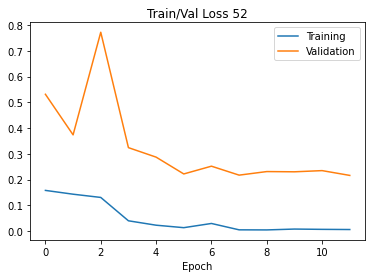

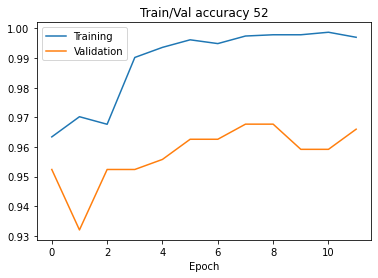

11/11 [==============================] - 0s 39ms/step - loss: 0.1872 - accuracy: 0.9633
(0.18720942735671997, 0.963302731513977)
11/11 [==============================] - 0s 38ms/step - loss: 0.1872 - accuracy: 0.9633


[0.18720942735671997, 0.963302731513977]

In [532]:
model = Model(inputs=effnet.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model, exp_id = experiment_controller.run_experiment(model, X_train, y_train)

print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(X_test, y_test))
model.evaluate(X_test, y_test)


#### Comparing Optimizers

In [533]:
# x = Dense(1024, activation = 'relu', kernel_initializer = GlorotUniform())(last_layer)
# x = Dense(512, activation='relu', kernel_initializer = GlorotUniform())(x)
# x = Dense(256, activation='relu', kernel_initializer = GlorotUniform())(x)
# predictions = Dense(4, activation="softmax", kernel_initializer = GlorotUniform())(x)

# model = Model(inputs=base_model.input, outputs=predictions)
# for optimizer in ['adam', 'nadam', 'adamax', 'adagrad', 'adadelta', 'rmsprop']:
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     model, exp_id = experiment_controller.run_experiment_generator(model, train_generator, val_generator)
#     print("ExperimentId:", exp_id, optimizer)
#     experiment_controller.plot_model_loss()
#     res = experiment_controller.test(X_test, y_test)
#     print(experiment_controller.classification_report(X_test, y_test))
#     print("Results: ", optimizer, " ", exp_id, " ", res)

Epoch 1/12
74/74 [==============================] - 40s 432ms/step - loss: 0.0996 - accuracy: 0.9719 - val_loss: 0.3145 - val_accuracy: 0.9439

Epoch 00001: val_accuracy improved from -inf to 0.94388, saving model to ./brain_tumor/experiment_52\checkpoint_52
Epoch 2/12
74/74 [==============================] - 14s 189ms/step - loss: 0.0530 - accuracy: 0.9860 - val_loss: 0.2113 - val_accuracy: 0.9677

Epoch 00002: val_accuracy improved from 0.94388 to 0.96769, saving model to ./brain_tumor/experiment_52\checkpoint_52
Epoch 3/12
74/74 [==============================] - 14s 190ms/step - loss: 0.0245 - accuracy: 0.9911 - val_loss: 0.2066 - val_accuracy: 0.9575

Epoch 00003: val_accuracy did not improve from 0.96769
Epoch 4/12
74/74 [==============================] - 14s 190ms/step - loss: 0.0168 - accuracy: 0.9957 - val_loss: 0.1915 - val_accuracy: 0.9575

Epoch 00004: val_accuracy did not improve from 0.96769

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.


C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_53\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_53\assets


ExperimentId: 53


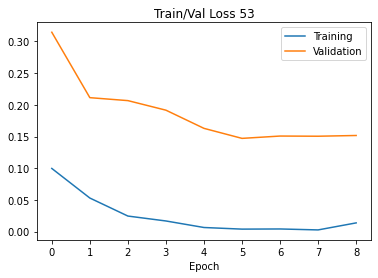

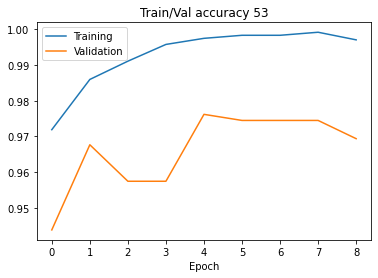

11/11 [==============================] - 0s 40ms/step - loss: 0.1156 - accuracy: 0.9664
(0.11559262871742249, 0.966360867023468)
11/11 [==============================] - 0s 39ms/step - loss: 0.1156 - accuracy: 0.9664
Results:  adam   53   (3.714775562286377, 0.7715736031532288)
Epoch 1/12
74/74 [==============================] - 64s 628ms/step - loss: 0.0419 - accuracy: 0.9902 - val_loss: 0.3280 - val_accuracy: 0.9439

Epoch 00001: val_accuracy improved from -inf to 0.94388, saving model to ./brain_tumor/experiment_53\checkpoint_53
Epoch 2/12
74/74 [==============================] - 22s 301ms/step - loss: 0.0934 - accuracy: 0.9783 - val_loss: 0.4999 - val_accuracy: 0.9456

Epoch 00002: val_accuracy improved from 0.94388 to 0.94558, saving model to ./brain_tumor/experiment_53\checkpoint_53
Epoch 3/12
74/74 [==============================] - 22s 296ms/step - loss: 0.0938 - accuracy: 0.9842 - val_loss: 7.1076 - val_accuracy: 0.5425

Epoch 00003: val_accuracy did not improve from 0.94558
E

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_54\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_54\assets


ExperimentId: 54


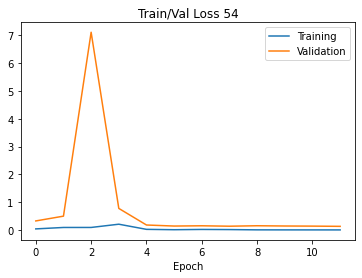

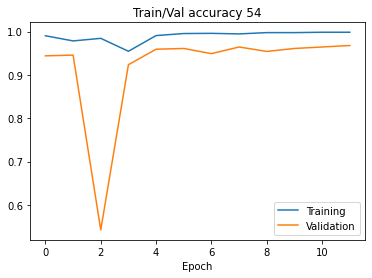

11/11 [==============================] - 0s 40ms/step - loss: 0.1204 - accuracy: 0.9786
(0.12041060626506805, 0.9785932898521423)
11/11 [==============================] - 0s 39ms/step - loss: 0.1204 - accuracy: 0.9786
Results:  nadam   54   (3.714775562286377, 0.7715736031532288)
Epoch 1/12
74/74 [==============================] - 33s 322ms/step - loss: 0.0193 - accuracy: 0.9949 - val_loss: 0.1586 - val_accuracy: 0.9609

Epoch 00001: val_accuracy improved from -inf to 0.96088, saving model to ./brain_tumor/experiment_54\checkpoint_54
Epoch 2/12
74/74 [==============================] - 14s 189ms/step - loss: 0.0160 - accuracy: 0.9962 - val_loss: 0.1048 - val_accuracy: 0.9762

Epoch 00002: val_accuracy improved from 0.96088 to 0.97619, saving model to ./brain_tumor/experiment_54\checkpoint_54
Epoch 3/12
74/74 [==============================] - 14s 189ms/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.1244 - val_accuracy: 0.9660

Epoch 00003: val_accuracy did not improve from 0.97619

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_55\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_55\assets


ExperimentId: 55


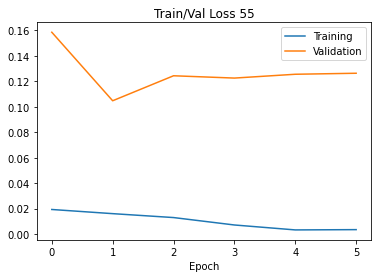

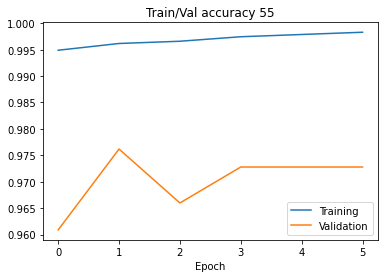

11/11 [==============================] - 0s 42ms/step - loss: 0.1510 - accuracy: 0.9755
(0.15098343789577484, 0.9755351543426514)
11/11 [==============================] - 0s 38ms/step - loss: 0.1510 - accuracy: 0.9755
Results:  adamax   55   (3.714775562286377, 0.7715736031532288)
Epoch 1/12
74/74 [==============================] - 32s 315ms/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.1039 - val_accuracy: 0.9762

Epoch 00001: val_accuracy improved from -inf to 0.97619, saving model to ./brain_tumor/experiment_55\checkpoint_55
Epoch 2/12
74/74 [==============================] - 14s 191ms/step - loss: 0.0078 - accuracy: 0.9987 - val_loss: 0.1048 - val_accuracy: 0.9762

Epoch 00002: val_accuracy did not improve from 0.97619
Epoch 3/12
74/74 [==============================] - 14s 192ms/step - loss: 0.0141 - accuracy: 0.9974 - val_loss: 0.1028 - val_accuracy: 0.9779

Epoch 00003: val_accuracy improved from 0.97619 to 0.97789, saving model to ./brain_tumor/experiment_55\checkpoint_5

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_56\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_56\assets


ExperimentId: 56


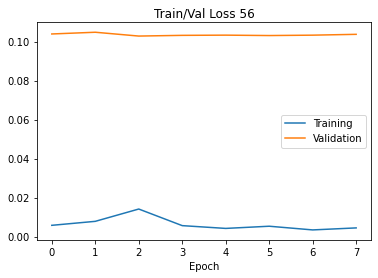

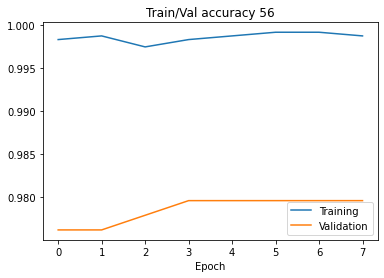

11/11 [==============================] - 0s 40ms/step - loss: 0.1529 - accuracy: 0.9755
(0.15285703539848328, 0.9755351543426514)
11/11 [==============================] - 0s 39ms/step - loss: 0.1529 - accuracy: 0.9755
Results:  adagrad   56   (3.714775562286377, 0.7715736031532288)
Epoch 1/12
74/74 [==============================] - 33s 324ms/step - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.1035 - val_accuracy: 0.9779

Epoch 00001: val_accuracy improved from -inf to 0.97789, saving model to ./brain_tumor/experiment_56\checkpoint_56
Epoch 2/12
74/74 [==============================] - 14s 194ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.1039 - val_accuracy: 0.9796

Epoch 00002: val_accuracy improved from 0.97789 to 0.97959, saving model to ./brain_tumor/experiment_56\checkpoint_56
Epoch 3/12
74/74 [==============================] - 17s 236ms/step - loss: 0.0055 - accuracy: 0.9991 - val_loss: 0.1039 - val_accuracy: 0.9796

Epoch 00003: val_accuracy did not improve from 0.979

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_57\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_57\assets


ExperimentId: 57


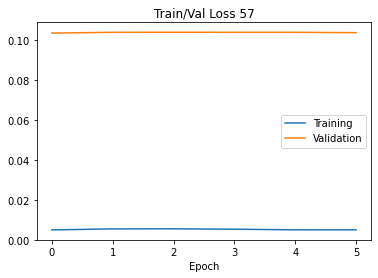

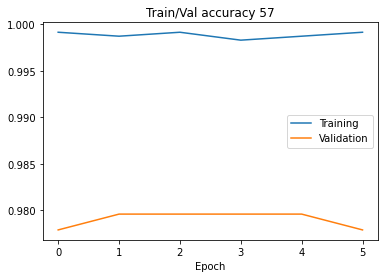

11/11 [==============================] - 0s 41ms/step - loss: 0.1538 - accuracy: 0.9755
(0.15378856658935547, 0.9755351543426514)
11/11 [==============================] - 0s 40ms/step - loss: 0.1538 - accuracy: 0.9755
Results:  adadelta   57   (3.714775562286377, 0.7715736031532288)
Epoch 1/12
74/74 [==============================] - 56s 585ms/step - loss: 0.0563 - accuracy: 0.9894 - val_loss: 0.3160 - val_accuracy: 0.9405

Epoch 00001: val_accuracy improved from -inf to 0.94048, saving model to ./brain_tumor/experiment_57\checkpoint_57
Epoch 2/12
74/74 [==============================] - 17s 234ms/step - loss: 0.0336 - accuracy: 0.9911 - val_loss: 0.3214 - val_accuracy: 0.9388

Epoch 00002: val_accuracy did not improve from 0.94048
Epoch 3/12
74/74 [==============================] - 17s 235ms/step - loss: 0.0410 - accuracy: 0.9906 - val_loss: 0.9549 - val_accuracy: 0.8980

Epoch 00003: val_accuracy did not improve from 0.94048

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_58\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_58\assets


ExperimentId: 58


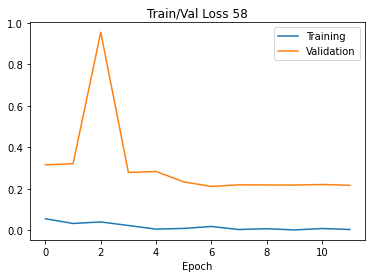

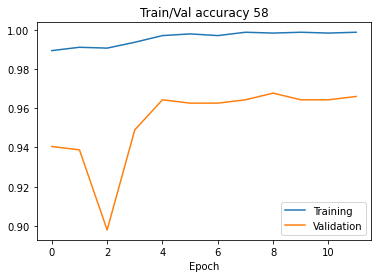

11/11 [==============================] - 0s 42ms/step - loss: 0.2376 - accuracy: 0.9755
(0.23757073283195496, 0.9755351543426514)
11/11 [==============================] - 0s 39ms/step - loss: 0.2376 - accuracy: 0.9755
Results:  rmsprop   58   (3.714775562286377, 0.7715736031532288)


In [534]:
x = effnet.output
x = Dense(1024, activation = 'relu', kernel_initializer = GlorotUniform())(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation="softmax", kernel_initializer = GlorotUniform())(x)

model = Model(inputs=effnet.input, outputs=predictions)
for optimizer in ['adam', 'nadam', 'adamax', 'adagrad', 'adadelta', 'rmsprop']:
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    model, exp_id = experiment_controller.run_experiment(model, X_train, y_train)

    print("ExperimentId:", exp_id)
    experiment_controller.plot_model_loss()
    experiment_controller.plot_model_loss("accuracy")
    print(experiment_controller.test(X_test, y_test))
    model.evaluate(X_test, y_test)
    
    print("Results: ", optimizer, " ", exp_id, " ", res)

**Adam parece ser el optimizador que mejor minimiza las funcion de costo para este problema**

#### Freezing EfficientNetb0

In [535]:
freeze_model(effnet)
x = effnet.output
x = Dense(1024, activation = 'relu', kernel_initializer = GlorotNormal(), use_bias=True, bias_initializer='zeros')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation="softmax", kernel_initializer = GlorotUniform(), use_bias=True, bias_initializer='zeros')(x)

model = Model(inputs=effnet.input, outputs=predictions)

Epoch 1/12
74/74 [==============================] - 16s 145ms/step - loss: 0.0262 - accuracy: 0.9898 - val_loss: 0.1478 - val_accuracy: 0.9626

Epoch 00001: val_accuracy improved from -inf to 0.96259, saving model to ./brain_tumor/experiment_58\checkpoint_58
Epoch 2/12
74/74 [==============================] - 4s 53ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.1425 - val_accuracy: 0.9694

Epoch 00002: val_accuracy improved from 0.96259 to 0.96939, saving model to ./brain_tumor/experiment_58\checkpoint_58
Epoch 3/12
74/74 [==============================] - 4s 52ms/step - loss: 0.0035 - accuracy: 0.9979 - val_loss: 0.1647 - val_accuracy: 0.9694

Epoch 00003: val_accuracy did not improve from 0.96939
Epoch 4/12
74/74 [==============================] - 4s 52ms/step - loss: 0.0016 - accuracy: 0.9991 - val_loss: 0.1821 - val_accuracy: 0.9592

Epoch 00004: val_accuracy did not improve from 0.96939

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 

C:\Users\mazg9\Anaconda3\envs\sl2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_59\assets


INFO:tensorflow:Assets written to: ./brain_tumor/experiment_59\assets


ExperimentId: 59


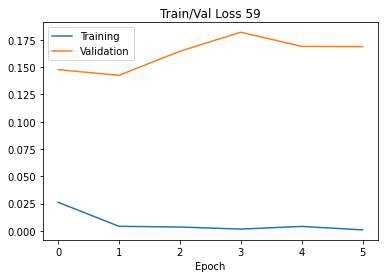

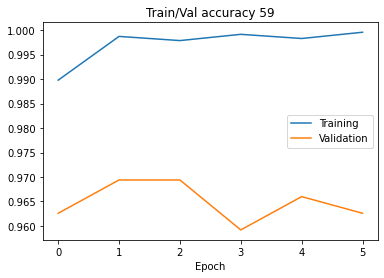

11/11 [==============================] - 0s 40ms/step - loss: 0.1497 - accuracy: 0.9755
(0.1497473120689392, 0.9755351543426514)
11/11 [==============================] - 0s 39ms/step - loss: 0.1497 - accuracy: 0.9755


[0.1497473120689392, 0.9755351543426514]

In [536]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model, exp_id = experiment_controller.run_experiment(model, X_train, y_train)

print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(X_test, y_test))
model.evaluate(X_test, y_test)

In [537]:
experiment_controller.summary_experiments().sort_values("val_accuracy", ascending=False)

,ExperimentID,Datetime,train_accuracy,val_accuracy
23,29,20210923-13:45:38,0.998451,0.982578
31,37,20210923-14:41:54,0.998839,0.982578
24,30,20210923-13:51:29,0.998839,0.982578
50,56,20210923-19:10:50,0.998723,0.979592
51,57,20210923-19:13:38,0.999149,0.977891
30,36,20210923-14:37:29,0.996516,0.975610
33,39,20210923-14:48:36,0.998839,0.975610
34,40,20210923-14:51:39,0.998064,0.975610
35,41,20210923-14:54:11,0.998839,0.975610
49,55,20210923-19:07:42,0.998297,0.972789


In [567]:
experiment_controller.compare_test_results().sort_values("test_accuracy", ascending=False)

,ExperimentID,Datetime,test_loss,test_accuracy,custom_metric
16,29,20210923-13:45:43,0.000171,1.000000,NaN
17,30,20210923-13:51:34,0.002075,0.999613,NaN
56,61,20210923-21:45:00,0.032492,0.990826,NaN
12,25,20210923-12:56:23,0.111263,0.978593,NaN
43,54,20210923-19:05:00,0.120411,0.978593,NaN
48,59,20210923-19:20:11,0.149747,0.975535,NaN
47,58,20210923-19:18:39,0.237571,0.975535,NaN
45,56,20210923-19:10:51,0.152857,0.975535,NaN
44,55,20210923-19:07:43,0.150983,0.975535,NaN
46,57,20210923-19:13:38,0.153789,0.975535,NaN


In [539]:
def plot_feature_maps(model, example, layer=0, filters_per_row=8, preprocess_input=lambda x: x):
    names = [layer.name for layer in model.layers if ('conv' in layer.name)]
    outputs = [layer.output for layer in model.layers if ('conv' in layer.name)]
    
    activation_model = Model(inputs=model.inputs,outputs=outputs)
    img = img_to_array(example)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    feature_maps = activation_model.predict(img)
    name = names[layer]
    fm = feature_maps[layer]
    
    n = fm.shape[-1]
    f, ax = plt.subplots(n, figsize=(20,20))

    ### render feature map
    for i in range(n):
        feature_img = fm[0, :, :, i]
        ax[i].imshow(feature_img)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    f.suptitle(f'Feature Map Layer {layer} {name}', fontsize=16, color='w')
    plt.show()

#### Plot Representations

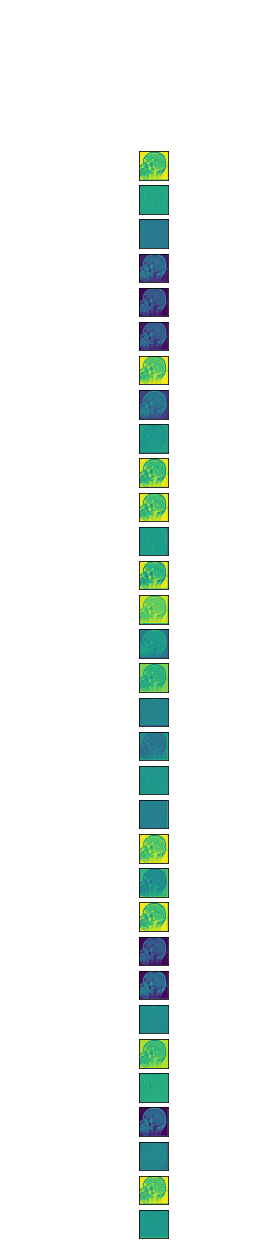

In [540]:
import warnings

with warnings.catch_warnings(record=True):
    model = experiment_controller.get_model(30)
    plot_feature_maps(model, X_test[0], layer=1)

In [541]:
%load_ext tensorboard
%tensorboard --logdir=brain_tumor/logs/tensorboard

Reusing TensorBoard on port 6006 (pid 21980), started 16:16:59 ago. (Use '!kill 21980' to kill it.)